In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import roc_curve, auc
from sklearn.calibration import CalibratedClassifierCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from bs4 import BeautifulSoup
import re
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from sklearn.manifold import TSNE
from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from sklearn.svm import SVC
import seaborn as sns
from tqdm import tqdm
import os

## Loading saved vectors

In [2]:
# loading bow vectors
X_train_bow = pickle.load(open("saved_feats/X_train_bow","rb"))
X_test_bow = pickle.load(open("saved_feats/X_test_bow","rb"))
bow_features = pickle.load(open("saved_feats/bow_features","rb")).tolist()
print('shape of X_train_bow is {}'.format(X_train_bow.shape))
print('shape of X_test_bow is {}'.format(X_test_bow.shape))


#loading tfidf vectors
X_train_tfidf = pickle.load(open("saved_feats/X_train_tfidf","rb"))
X_test_tfidf = pickle.load(open("saved_feats/X_test_tfidf","rb"))
tfidf_features = pickle.load(open("saved_feats/tfidf_features","rb")).tolist()
print('shape of X_train_tfidf is {}'.format(X_train_tfidf.shape))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.shape))


w2v_words = pickle.load(open("saved_feats/w2v_words","rb")).tolist()
#avgw2v
X_train_avgw2v = pickle.load(open("saved_feats/X_train_avgw2v","rb"))
X_test_avgw2v = pickle.load(open("saved_feats/X_test_avgw2v","rb"))
print('shape of X_train_avgw2v is {}'.format(X_train_avgw2v.shape))
print('shape of X_test_avgw2v is {}'.format(X_test_avgw2v.shape))


#tfidf-w2v
X_train_tfw2v = pickle.load(open("saved_feats/X_train_tfw2v","rb"))
X_test_tfw2v = pickle.load(open("saved_feats/X_test_tfw2v","rb"))
print('shape of X_train_tfw2v is {}'.format(X_train_tfw2v.shape))
print('shape of X_test_tfw2v is {}'.format(X_test_tfw2v.shape))


y_tr = np.load('saved_feats/y_train.npy',allow_pickle=True)
y_test = np.load('saved_feats/y_test.npy',allow_pickle=True)
print(f'shape of y_train is {y_tr.shape}')
print(f'shape of y_test is {y_test.shape}')

shape of X_train_bow is (70000, 51047)
shape of X_test_bow is (30000, 51047)
shape of X_train_tfidf is (70000, 51047)
shape of X_test_tfidf is (30000, 51047)
shape of X_train_avgw2v is (70000, 50)
shape of X_test_avgw2v is (30000, 50)
shape of X_train_tfw2v is (70000, 50)
shape of X_test_tfw2v is (30000, 50)
shape of y_train is (70000,)
shape of y_test is (30000,)


In [3]:
# helper function to plot confusion matrix
def plot_confusion_matrixes(model,x_train,y_train,x_test,y_test):
    cm_train = confusion_matrix(y_train,model.predict(x_train))
    cm_test =  confusion_matrix(y_test,model.predict(x_test))
    class_label = ["negative", "positive"]
    df_train = pd.DataFrame(cm_train, index = class_label, columns = class_label)
    df_test = pd.DataFrame(cm_test, index = class_label, columns = class_label)
    f, axes = plt.subplots(1, 2,figsize=(12,4))

    for i in range(2):
      df = df_train if i==0 else df_test
      sns.heatmap(df, annot = True, fmt = "d",ax=axes[i])
      axes[i].set_title(f"Confusion Matrix - {'Train' if i==0 else 'Test'}")
      axes[i].set_xlabel("Predicted Label")
      axes[i].set_ylabel("True Label")
    plt.show()


# Linear SVM

# [1] Linear SVM On Bag of Words

We will use SGD classifier here. It is similar to Linear 
SVM with SGD implementation.

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


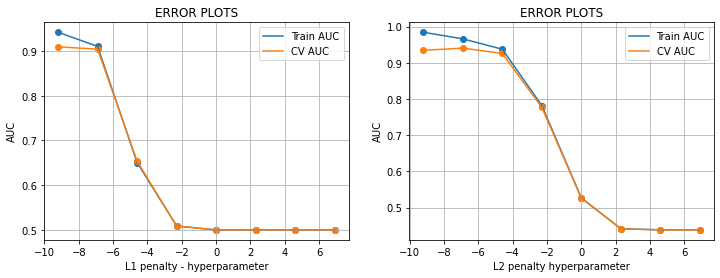

In [4]:

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

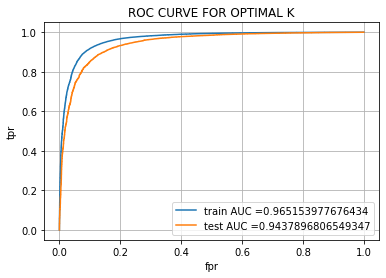

Area under train roc 0.965153977676434
Area under test roc 0.9437896806549347


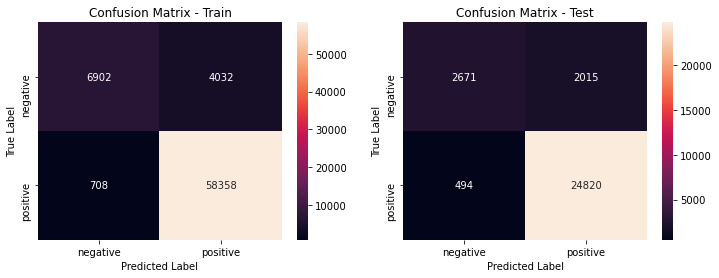

In [5]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_bow,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_bow,y_tr,X_test_bow,y_test)

> Why use CaliberatedCV? 

SVM by default cannot gives the probability of target variables. So we use CaliberatedCV to get it as it is used for calculation of our metrics(AUC)

.

## [2] Linear SVM ON TFIDF

Model with best parameters :
 {'alpha': 0.0001, 'penalty': 'l2'}


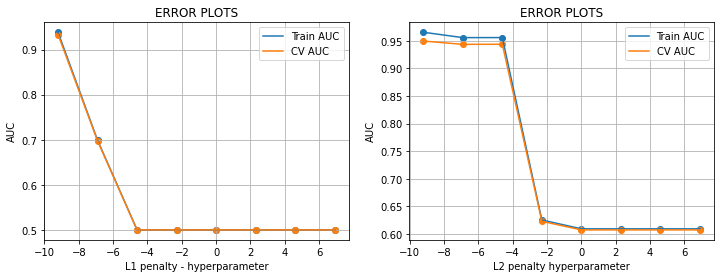

In [6]:

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

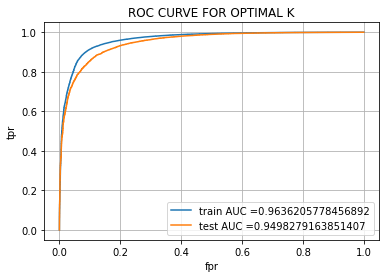

Area under train roc 0.9636205778456892
Area under test roc 0.9498279163851407


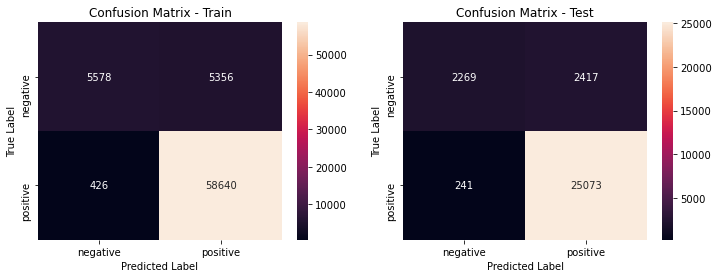

In [7]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_tfidf,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_tfidf,y_tr,X_test_tfidf,y_test)

## [3] Linear SVM On AVG Word2Vec

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l2'}


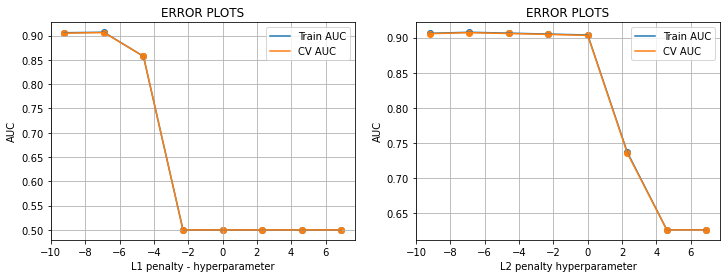

In [8]:

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_avgw2v, y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

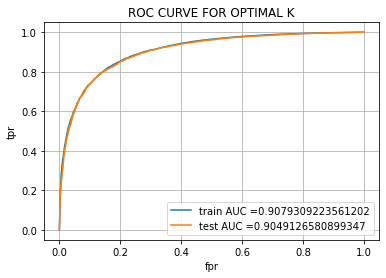

Area under train roc 0.9079309223561202
Area under test roc 0.9049126580899347


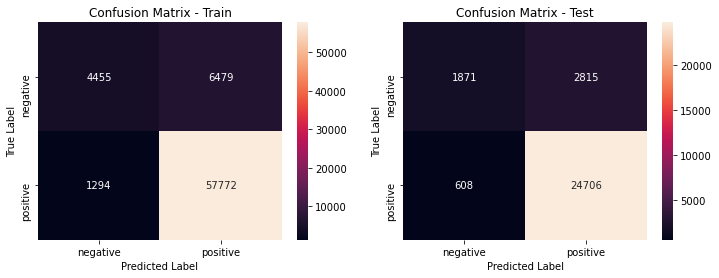

In [9]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_avgw2v,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

# [4] Linear SVM On TFIDF - Word2Vec

Model with best parameters :
 {'alpha': 0.001, 'penalty': 'l1'}


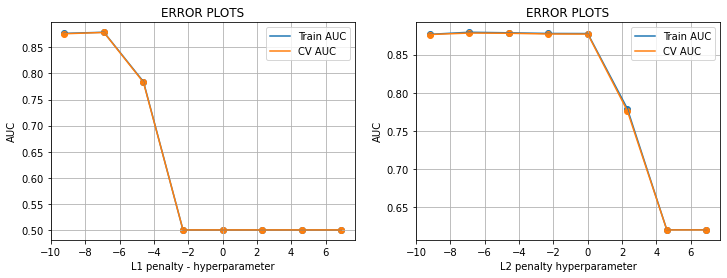

In [10]:

Alpha = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000] 
penalty = ['l1', 'l2']
opt = SGDClassifier()
parameters = {'alpha':Alpha,'penalty':penalty}
model = GridSearchCV(SGDClassifier(), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5, return_train_score=True)
model.fit(X_train_tfw2v, y_tr)
print("Model with best parameters :\n",model.best_params_)

f, axes = plt.subplots(1, 2,figsize=(12,4))

for i in range(2):
  title = 'L1 penalty - hyperparameter' if i ==0 else 'L2 penalty hyperparameter'
  train_auc = model.cv_results_['mean_train_score'][0+i:16+i:2]
  cv_auc = model.cv_results_['mean_test_score'][0+i:16+i:2]
  axes[i].plot(np.log(Alpha), train_auc, label='Train AUC')
  axes[i].plot(np.log(Alpha), cv_auc, label='CV AUC')
  axes[i].scatter(np.log(Alpha), train_auc)
  axes[i].grid(True)
  axes[i].legend()
  axes[i].scatter(np.log(Alpha), cv_auc)
  axes[i].set_xlabel(title)
  axes[i].set_ylabel("AUC")
  axes[i].set_title("ERROR PLOTS")

plt.show()

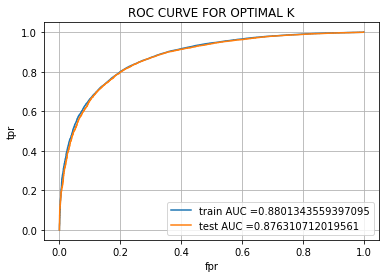

Area under train roc 0.8801343559397095
Area under test roc 0.876310712019561


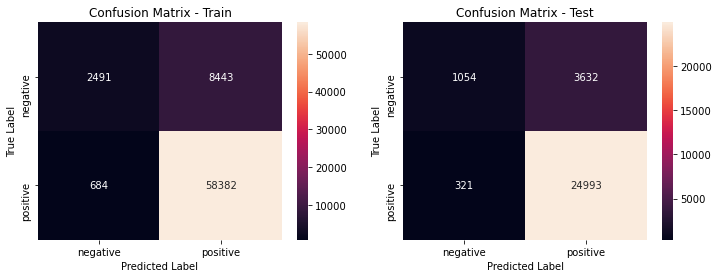

In [11]:
svm_opt = SGDClassifier(**model.best_params_) 
svm_opt.fit(X_train_tfw2v,y_tr)
best_est = CalibratedClassifierCV(base_estimator=svm_opt)
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(svm_opt,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)

.

.

# SVM RBF Kernel Classifier

Note: RBF kernel SVM is very computationaly expensive.So we will try with 20k datapoints

In [12]:
df = pd.read_csv('processed_df.csv')
#one row is empty.we will drop it
df = df.dropna(axis=0)
# #sampling 100k points 
df = df.sample(20000,random_state=100)
#sortimg based on time
df['Time'] = pd.to_datetime(df['Time'],unit='s')
df = df.sort_values('Time')
df = df.reset_index(drop=True)
df.shape

(20000, 3)

In [13]:
#splitting data to train.cv and test
from sklearn.model_selection import train_test_split
x = df['clean_text']
y = df['Score']
X_tr,X_test,y_tr,y_test = train_test_split(x,y,test_size=0.3,stratify=y,random_state=100)

# [1] SVM RBF On BOW

In [14]:
bow = CountVectorizer(min_df=10,max_features=500)
bow.fit(X_tr)
X_train_bow = bow.transform(X_tr)
X_test_bow = bow.transform(X_test)
bow_features = bow.get_feature_names()

print('shape of X_train_bow is {}'.format(X_train_bow.get_shape()))
print('shape of X_test_bow is {}'.format(X_test_bow.get_shape()))

shape of X_train_bow is (14000, 500)
shape of X_test_bow is (6000, 500)


Model with best parameters :
 {'C': 10, 'gamma': 0.01}


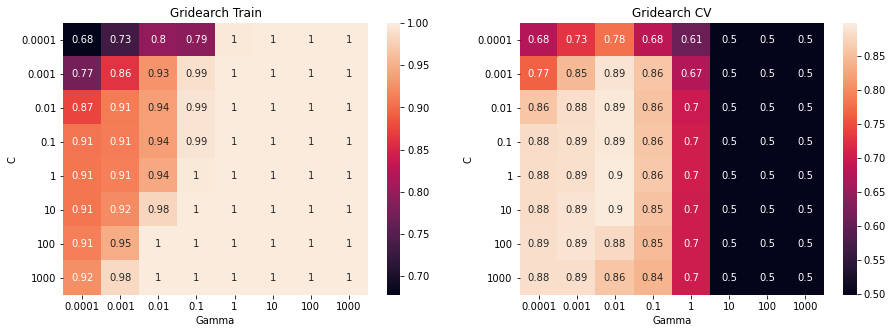

In [15]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=5,return_train_score=True)
model.fit(X_train_bow,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show()

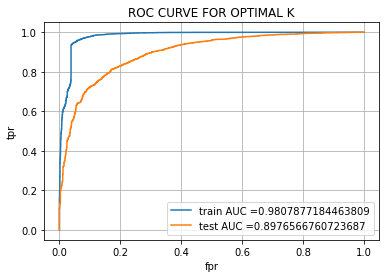

Area under train roc 0.9807877184463809
Area under test roc 0.8976566760723687


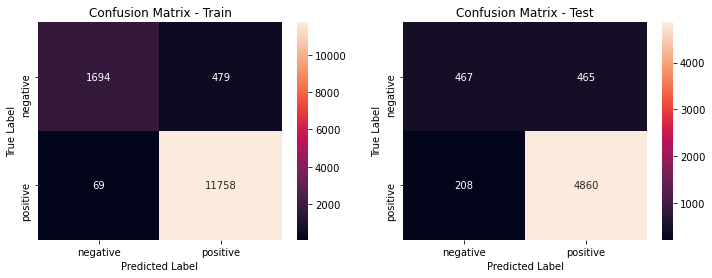

In [16]:

best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_bow,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_bow)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_bow,y_tr,X_test_bow,y_test)

# [2] SVM RBF On TFIDF

In [17]:
#applying tfidf on x_train and x_test
vectorizer = TfidfVectorizer(min_df=10,max_features=500)
vectorizer.fit(X_tr)
# we use the fitted CountVectorizer to convert the text to vector
X_train_tfidf = vectorizer.transform(X_tr)
X_test_tfidf = vectorizer.transform(X_test)

print('shape of X_train_tfidf is {}'.format(X_train_tfidf.get_shape()))
print('shape of X_test_tfidf is {}'.format(X_test_tfidf.get_shape()))

shape of X_train_tfidf is (14000, 500)
shape of X_test_tfidf is (6000, 500)


Model with best parameters :
 {'C': 100, 'gamma': 1}


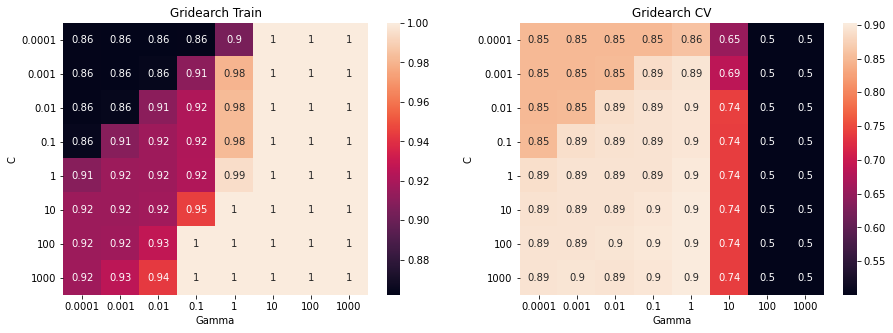

In [18]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
model.fit(X_train_tfidf,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show()

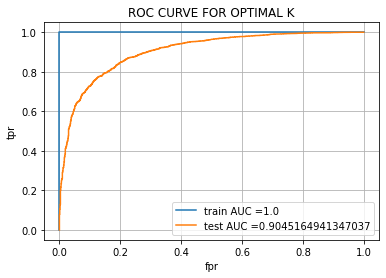

Area under train roc 1.0
Area under test roc 0.9045164941347037


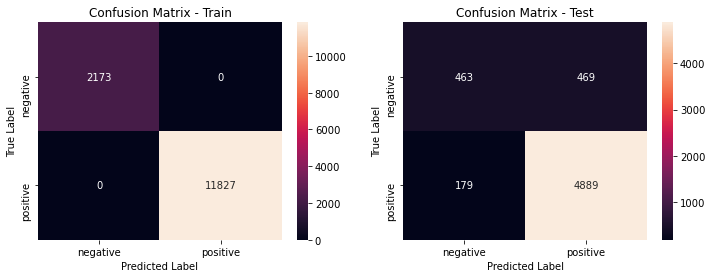

In [19]:
from sklearn.svm import SVC
best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_tfidf,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfidf)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfidf,y_tr,X_test_tfidf,y_test)

# [3] SVM RBF ON Avg Word2Vec

In [20]:
# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values

train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)

w2v_words_train = list(w2v_model_train.wv.vocab)
#################################################################################
# compute average word2vec for each review for train data.
preprocessed_reviews = X_tr.values
list_of_sentancetrain = []
for sentance in preprocessed_reviews:
    list_of_sentancetrain.append(sentance.split())


sent_vectors_train = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetrain): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))
print(len(sent_vectors_train[0]))

###########################################################


# compute average word2vec for each review for test data.
preprocessed_reviews = X_test.values
list_of_sentancetest = []
for sentance in preprocessed_reviews:
    list_of_sentancetest.append(sentance.split())

sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentancetest): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words_train:
            vec = w2v_model_train.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

X_train_avgw2v = sent_vectors_train
X_test_avgw2v = sent_vectors_test

100%|███████████████████████████████████████████████████████████████████████████| 14000/14000 [00:17<00:00, 798.64it/s]


14000
50


100%|█████████████████████████████████████████████████████████████████████████████| 6000/6000 [00:07<00:00, 774.80it/s]

6000
50


Model with best parameters :
 {'C': 100, 'gamma': 0.01}


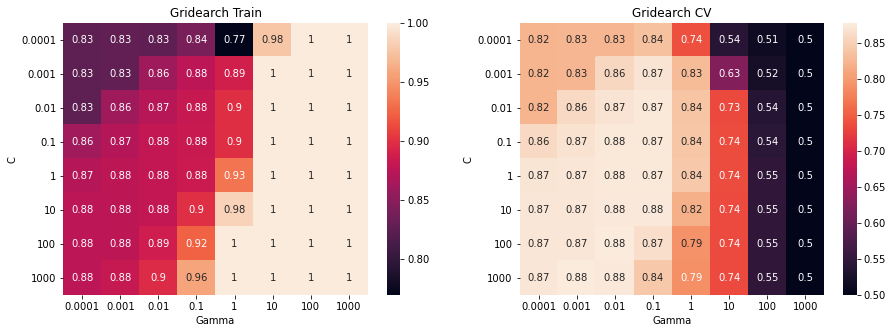

In [21]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
model.fit(X_train_avgw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show()

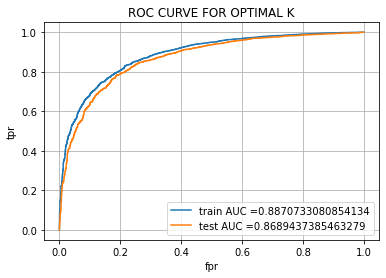

Area under train roc 0.8870733080854134
Area under test roc 0.8689437385463279


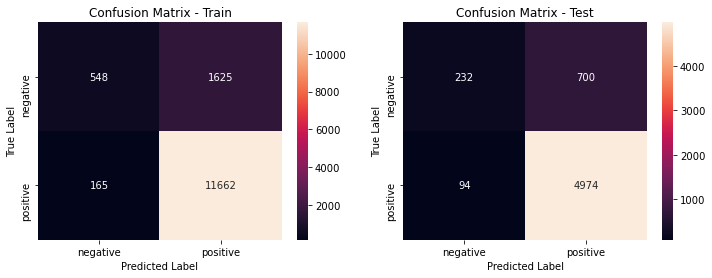

In [22]:

best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_avgw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_avgw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_avgw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))

plot_confusion_matrixes(best_est,X_train_avgw2v,y_tr,X_test_avgw2v,y_test)

# [4] SVM RBF On TFIDF Word2Vec

In [23]:

# Train your own Word2Vec model using your own text corpus
preprocessed_reviews = X_tr.values

train_sentance=[]
for sentance in preprocessed_reviews:
    train_sentance.append(sentance.split())

w2v_model_train=Word2Vec(train_sentance,min_count=5,size=50, workers=4)

w2v_words = list(w2v_model_train.wv.vocab)
#####################################################################
tfidf = TfidfVectorizer()
tfidf.fit(X_tr)
dictionary = dict(zip(tfidf.get_feature_names(), list(tfidf.idf_)))
tfidf_feats = tfidf.get_feature_names()

train_reviews = X_tr.values
train_sentence = [rev.split() for rev in train_reviews]
sent_vectors_train = []
for sent in tqdm(train_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_train.append(sent_vec)
print(len(sent_vectors_train))


######################################################################

test_reviews = X_test.values
test_sentence = [rev.split() for rev in test_reviews]
sent_vectors_test = []
for sent in tqdm(test_sentence):
    sent_vec = np.zeros(50)
    weight_sum = 0
    for word in sent:
        if word in tfidf_feats and word in w2v_words:
            vec = w2v_model_train.wv[word]
            # tf * idf
            tfidf_value = (sent.count(word)/len(sent)) * dictionary[word] 
            vec = vec * tfidf_value
            sent_vec += vec
            weight_sum += tfidf_value
    if weight_sum != 0:
        sent_vec /= weight_sum
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))


X_train_tfw2v = sent_vectors_train
X_test_tfw2v = sent_vectors_test

100%|████████████████████████████████████████████████████████████████████████████| 14000/14000 [02:36<00:00, 89.51it/s]


14000


100%|██████████████████████████████████████████████████████████████████████████████| 6000/6000 [01:08<00:00, 88.02it/s]

6000


Model with best parameters :
 {'C': 100, 'gamma': 0.01}


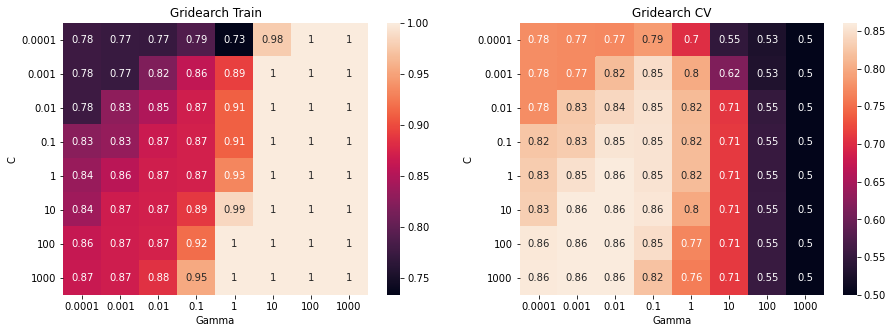

In [24]:
from sklearn.svm import SVC
c = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
Gamma = [0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]
parameters = {'C':c,'gamma': Gamma}
model = GridSearchCV(SVC(kernel='rbf'), param_grid=parameters,n_jobs=-1, scoring='roc_auc',cv=3,return_train_score=True)
model.fit(X_train_tfw2v,y_tr)
print("Model with best parameters :\n",model.best_params_)
train_auc = model.cv_results_['mean_train_score'].reshape(8,8)
cv_auc = model.cv_results_['mean_test_score'].reshape(8,8)
f, axes = plt.subplots(1, 2,figsize=(15,5))

for i in range(2):
  title = train_auc if i == 0 else cv_auc
  sns.heatmap(title,xticklabels=Gamma,yticklabels=c,annot=True,ax=axes[i])
  axes[i].set_title(f"Gridearch {'Train' if i==0 else 'CV'}")
  axes[i].set_xlabel("Gamma")
  axes[i].set_ylabel("C")


plt.show()

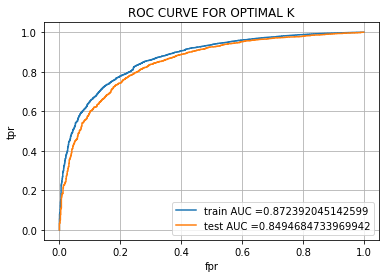

Area under train roc 0.872392045142599
Area under test roc 0.8494684733969942


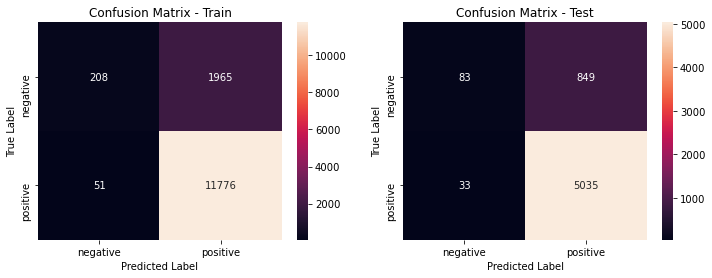

In [25]:

best_est = SVC(**model.best_params_,probability=True)
best_est = best_est.fit(X_train_tfw2v,y_tr)
train_fpr, train_tpr, thresholds = roc_curve(y_tr, best_est.predict_proba(X_train_tfw2v)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, best_est.predict_proba(X_test_tfw2v)[:,1])

plt.grid(True)
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("fpr")
plt.ylabel("tpr")
plt.title("ROC CURVE FOR OPTIMAL K")
plt.show()

#Area under ROC curve
print('Area under train roc {}'.format(auc(train_fpr, train_tpr)))
print('Area under test roc {}'.format(auc(test_fpr, test_tpr)))
plot_confusion_matrixes(best_est,X_train_tfw2v,y_tr,X_test_tfw2v,y_test)


# Observations and Conclusion

In [26]:
from prettytable import PrettyTable
    
z = PrettyTable()

z.field_names = ["Vector","Algorithm","kernel","penalty","Hyperparam-alpha","Hyperparam-C","gamma","Train AUC", "Test AUC"]

z.add_row(["bow","SVM","linear","l2",0.001,"-","-",0.9647384502935005,0.9449183281172104])
z.add_row(["tfidf","SVM","linear","l2",0.0001,"-","-",0.9631018867419676,0.9518420116741007])
z.add_row(["avg-w2v","SVM","linear","l2",0.0001,"-","-",0.9095848447875141,0.9101469427726214])
z.add_row(["tfidf-w2v","SVM","linear","l2",0.001,"-","-",0.8840266485280304,0.8828121426206832])
z.add_row(["bow","SVM","RBF","-","-",10,0.01,0.980429120215271,0.8972464821771546])
z.add_row(["tfidf","SVM","RBF","-","-",10,1,0.9999147710614344,0.9299163158333463])
z.add_row(["avg-w2v","SVM","RBF","-","-",100,0.01,0.9043063493210701,0.9048901941915043])
z.add_row(["tfidf-w2v","SVM","RBF","-","-",1000,0.01,0.8979185918936899,0.8832558625135044])
print(z)


+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|   Vector  | Algorithm | kernel | penalty | Hyperparam-alpha | Hyperparam-C | gamma |     Train AUC      |      Test AUC      |
+-----------+-----------+--------+---------+------------------+--------------+-------+--------------------+--------------------+
|    bow    |    SVM    | linear |    l2   |      0.001       |      -       |   -   | 0.9647384502935005 | 0.9449183281172104 |
|   tfidf   |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9631018867419676 | 0.9518420116741007 |
|  avg-w2v  |    SVM    | linear |    l2   |      0.0001      |      -       |   -   | 0.9095848447875141 | 0.9101469427726214 |
| tfidf-w2v |    SVM    | linear |    l2   |      0.001       |      -       |   -   | 0.8840266485280304 | 0.8828121426206832 |
|    bow    |    SVM    |  RBF   |    -    |        -         |      10      |  0.01 | 0.98042912

* SVM performs good with our text data.
* Some of the linear SVM models are slightly overfitting.
* As RBF kernels are computationally expensive we only used 20000 points. Eventhen the model is performing well. Eventhough our RBF based models are overfitting, it can be overcome by using more train data.
* Here out of all our model we have a more generalized model with linear SVM on average word2vec vectors.